# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.15$, $\alpha=2$) ($\tau$ slightly low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau = 1.15
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

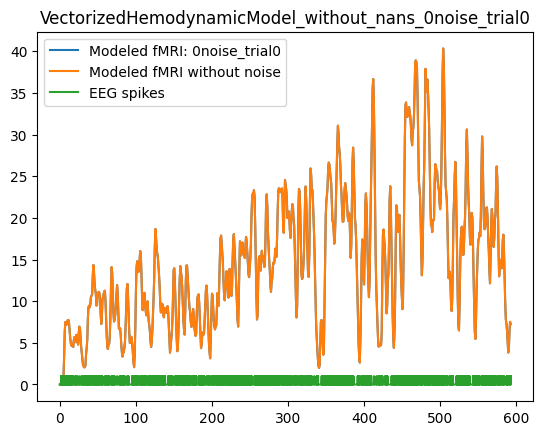

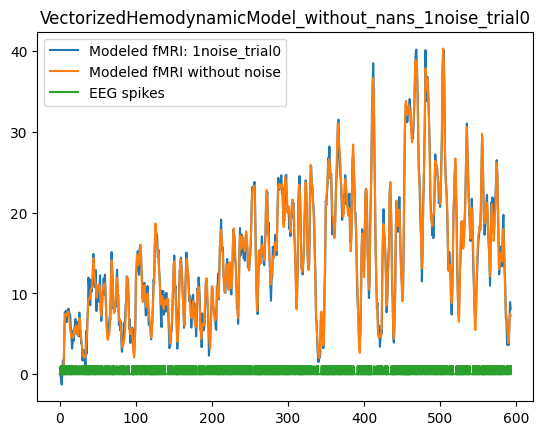

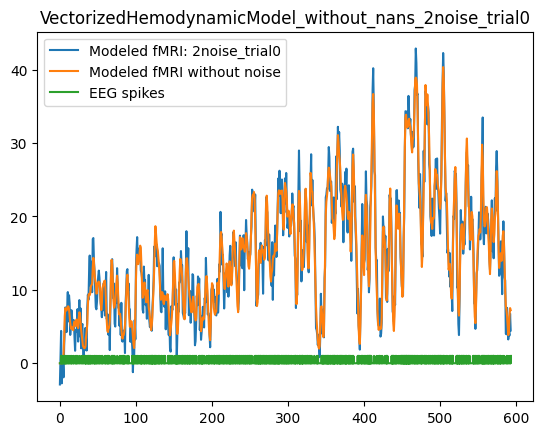

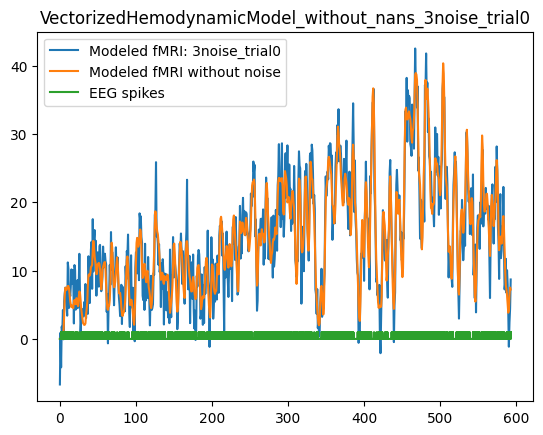

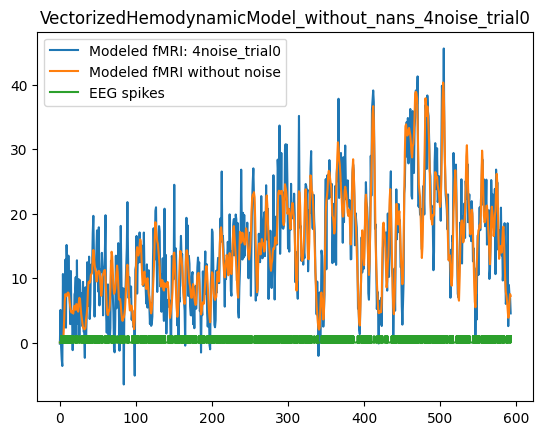

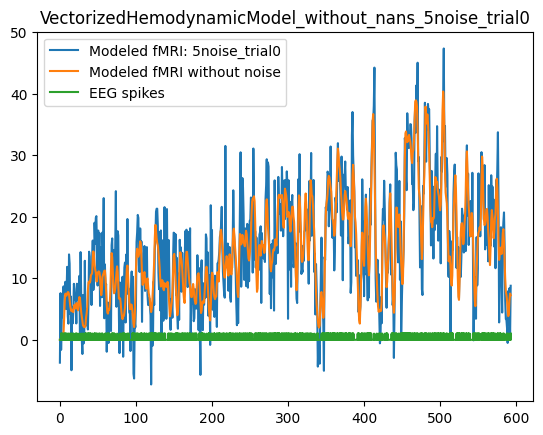

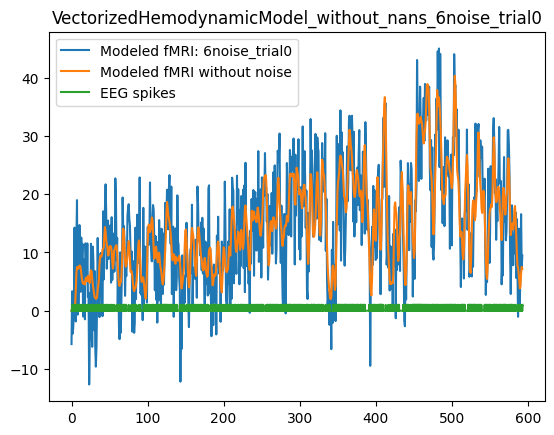

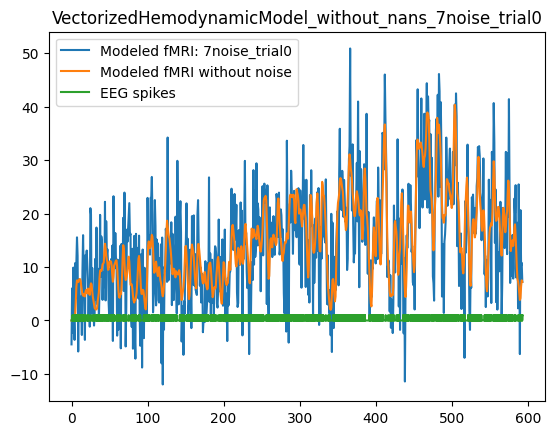

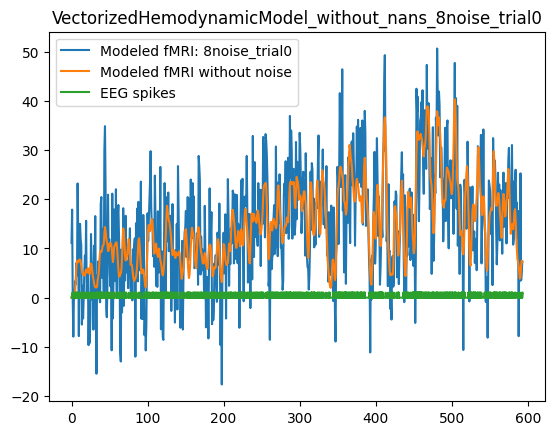

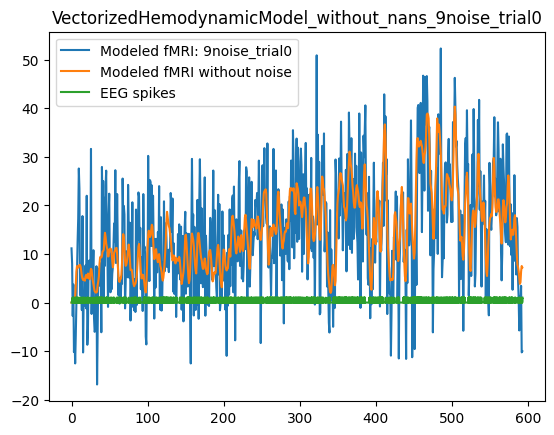

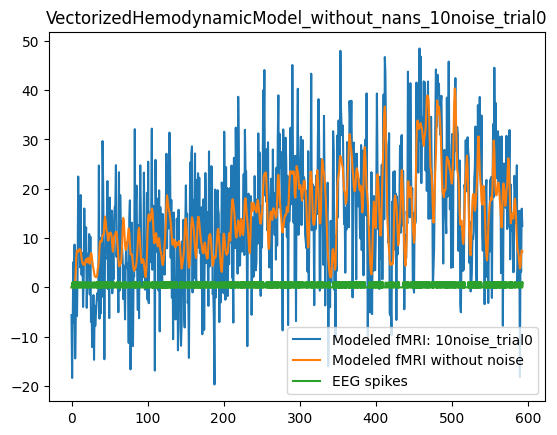

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.15, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.15, alpha=2


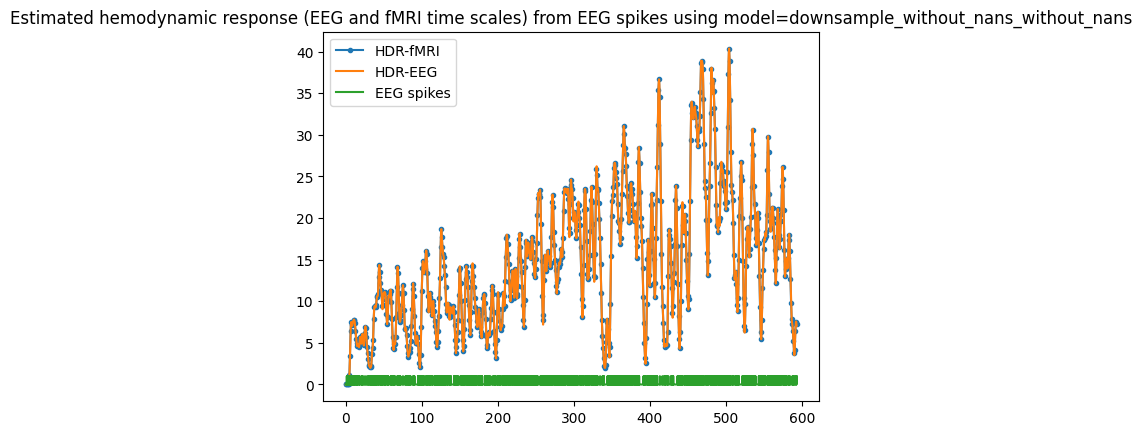

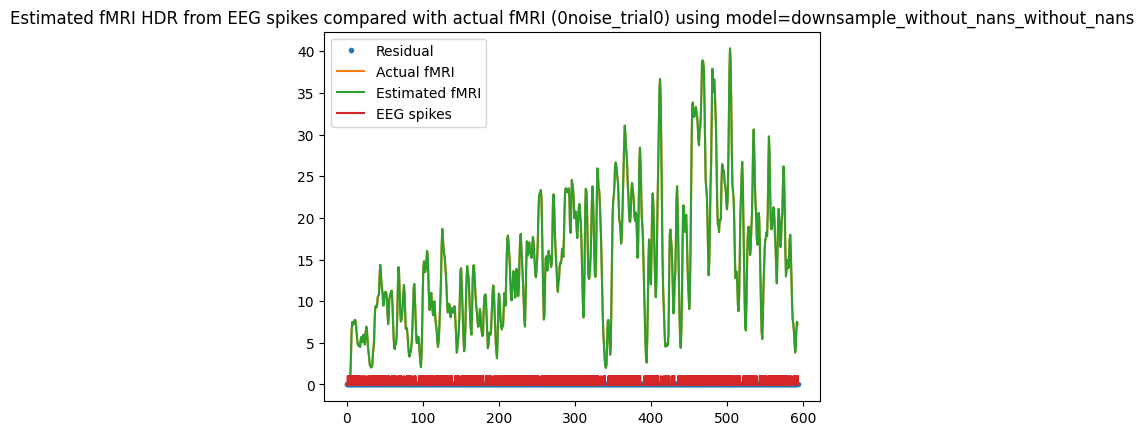

Residual Variance is 0.000000


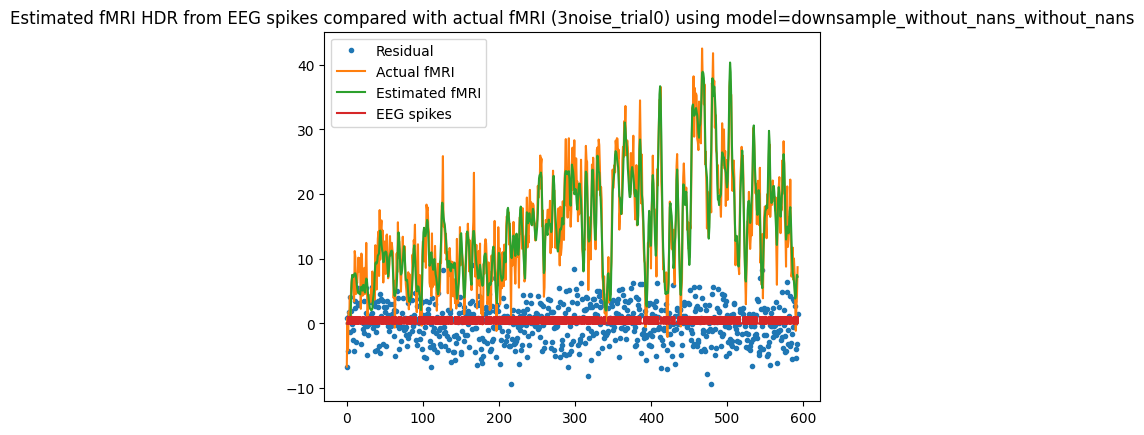

Residual Variance is 9.243754


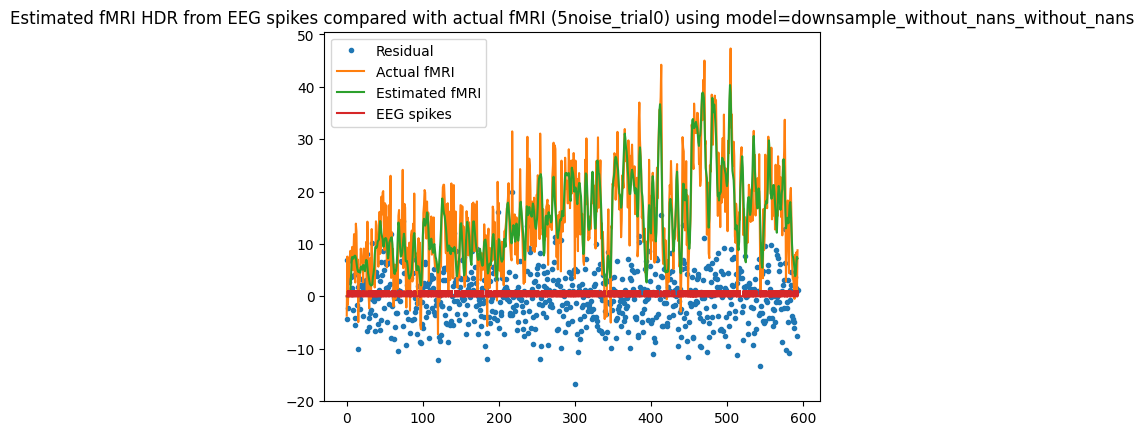

Residual Variance is 25.271976


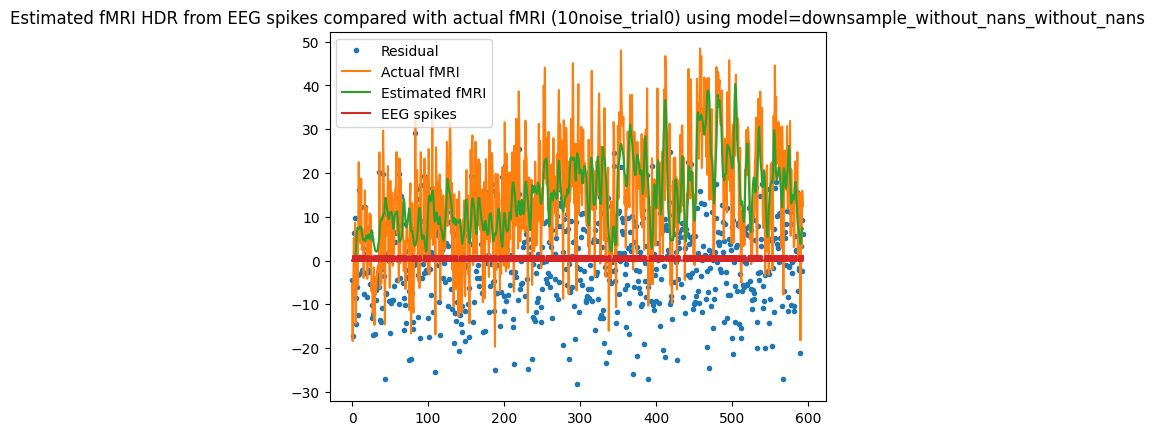

Residual Variance is 106.784692


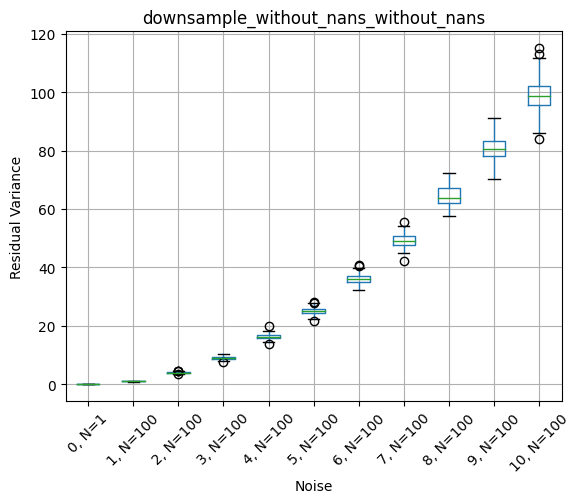

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.15, alpha=2


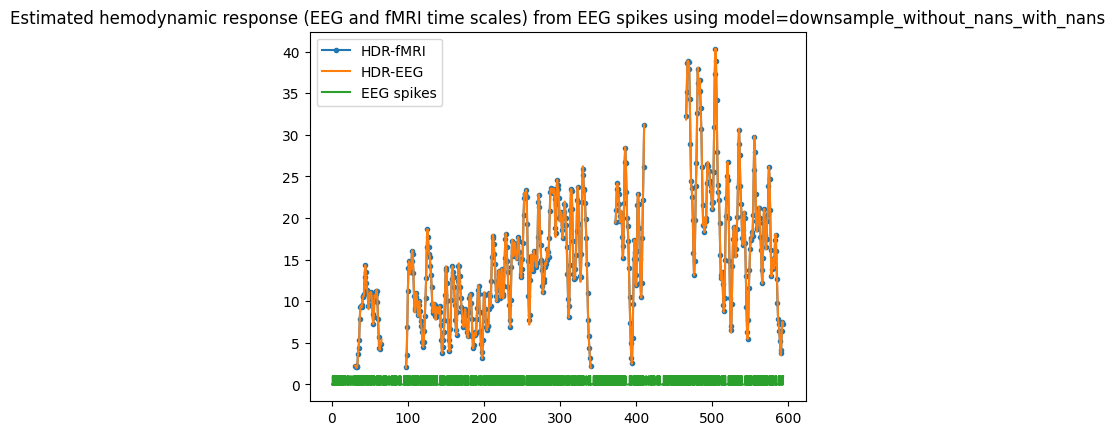

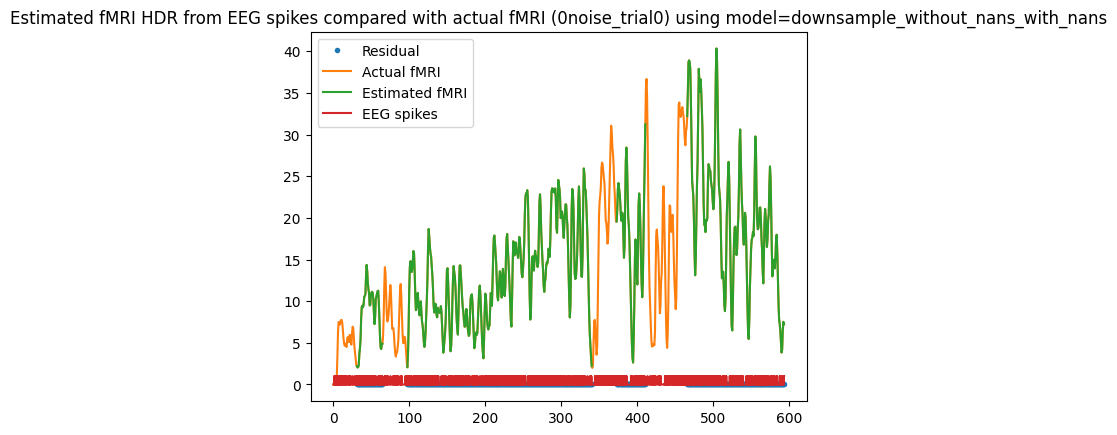

Residual Variance is 0.000000


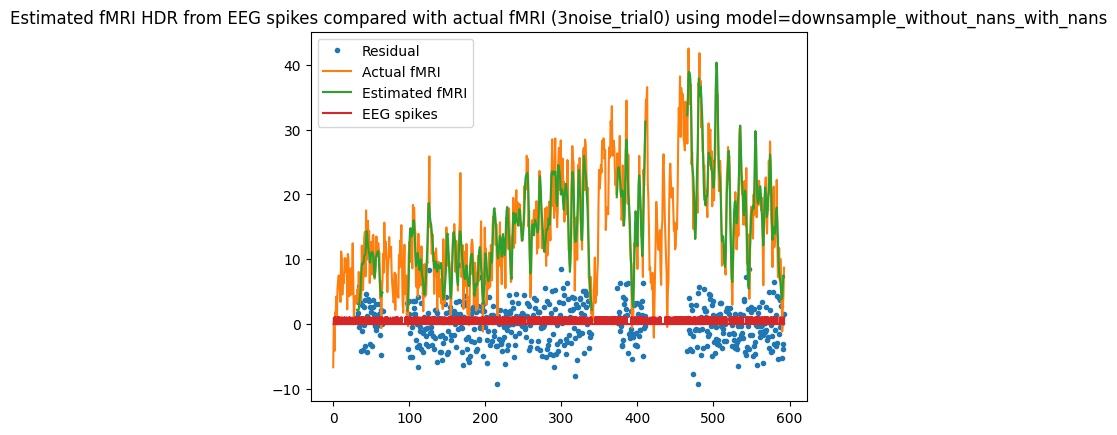

Residual Variance is 9.676937


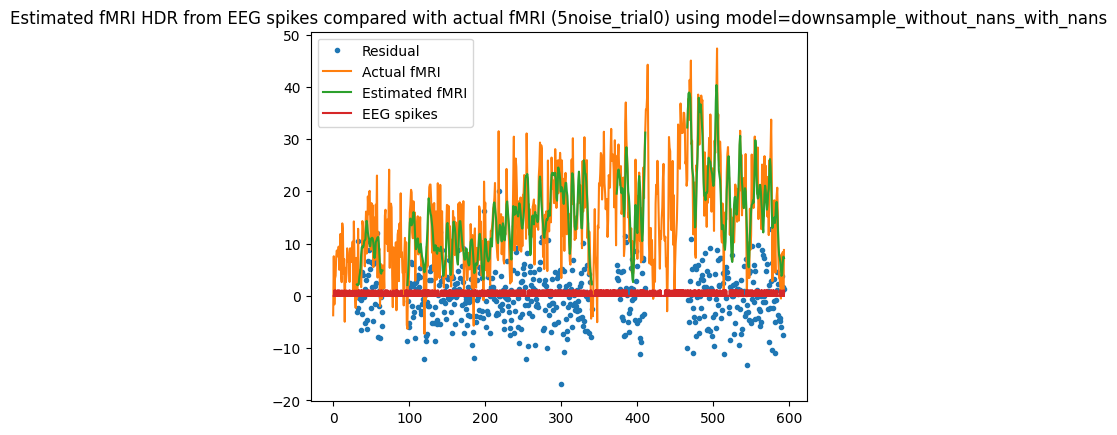

Residual Variance is 25.705885


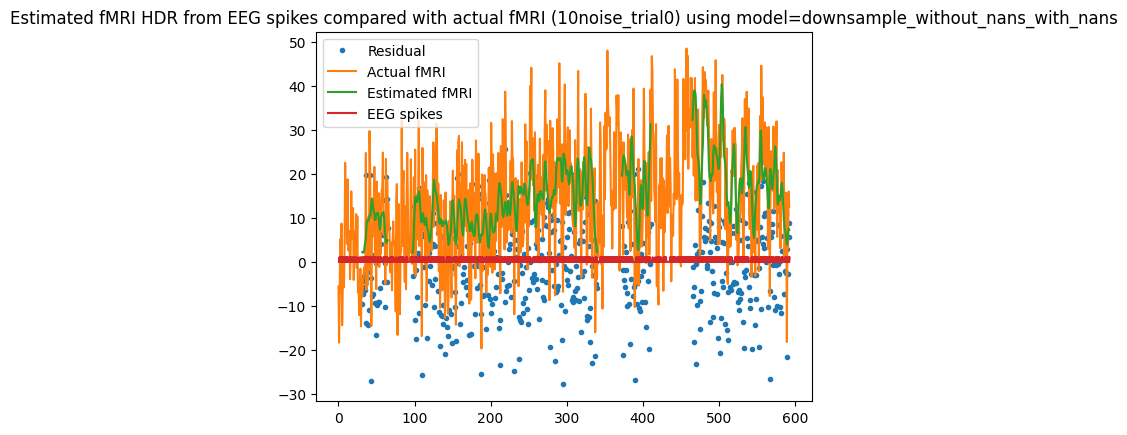

Residual Variance is 108.120666


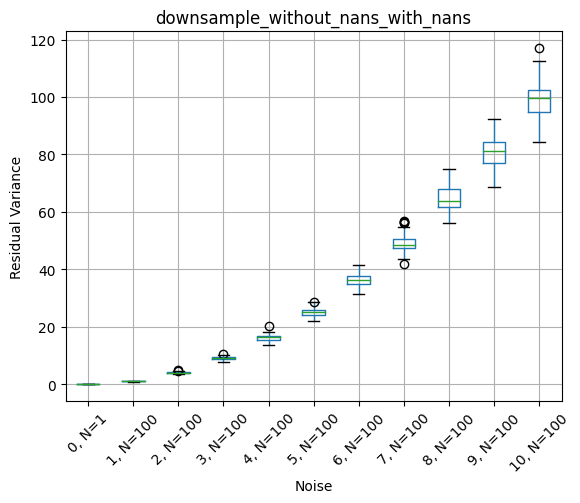

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  36.411809678337384   
1         downsample_without_nans_with_nans   33.56898902133597   
2      downsample_without_nans_without_nans   35.59682817617097   
3         downsample_without_nans_with_nans   32.86279340621631   
4      downsample_without_nans_without_nans   34.77499950564918   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  15.781318549651319   
18938  downsample_without_nans_without_nans  17.899217983316902   
18939     downsample_without_nans_with_nans   16.42722335283772   
18940  downsample_without_nans_without_nans  18.622823416649467   
18941     downsample_without_nans_with_nans  17.062426310772114   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       37.52338966119763    41.4806914814115  45.283030538580135   
1       34.88190402244476   37.69701236645388   43.85038781114493   
2       36.72457437142626   40.64549975011707   44.46190350263094   
3       34.18570633480548   36.97810178167723  43.136396756811834   
4      35.918545997318134   39.80297566834274   43.63365693929951   
...                   ...                 ...                 ...   
18937   16.34147744460145  20.612472638040817  25.559105588187194   
18938     18.507049052347   22.43803529607838  27.401811944078048   
18939    16.9917202730488  21.264089959718646  26.194283713295704   
18940  19.233406403674703   23.17931726984311  28.116352689415127   
18941   17.63224259273988   21.90342748785922  26.818301178952936   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       51.80164875962871   60.03065417066069  ...   37.75560882411068   
1       47.74232187373466   57.60823137945275  ...   35.56357284924928   
2       51.08181346462523  59.255940103445596  ...   36.93539550664069   
3      47.107624032913186   56.94073056722364  ...   34.84563674705823   
4      50.352683511655954   58.47339597745876  ...  36.107972264687106   
...                   ...                 ...  ...                 ...   
18937  29.757635133916967   41.10486931559952  ...  16.961308187404043   
18938   32.23095668533922   43.88577416863796  ...   18.93536009530391   
18939   30.36740948780597  41.735010459489196  ...  17.611882435400258   
18940   32.92185014529213   44.59069683240929  ...  19.653964933828846   
18941   30.96700283180015  42.355316642238506  ...  18.251651018202686   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       40.50476831869223   44.82792971540197  49.628551246892805   
1        37.9547064616683  42.719581204910504   45.88234183659552   
2      39.675257445866954  44.004621215362256   48.81252612775618   
3       37.22572268157458   41.97588720126999   45.17192098389127   
4       38.83948082102322    43.1744446940072   47.99106925681923   
...                   ...                 ...                 ...   
18937  21.097291813498934   24.12619132796495  30.677160098470704   
18938  22.803436421031048   26.11408766924166   33.26663343529109   
18939  21.768580937918447   24.75647534428361  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.3604453508875278e-28; at
       delta   tau  alpha
11736   2.25  1.15    2.0


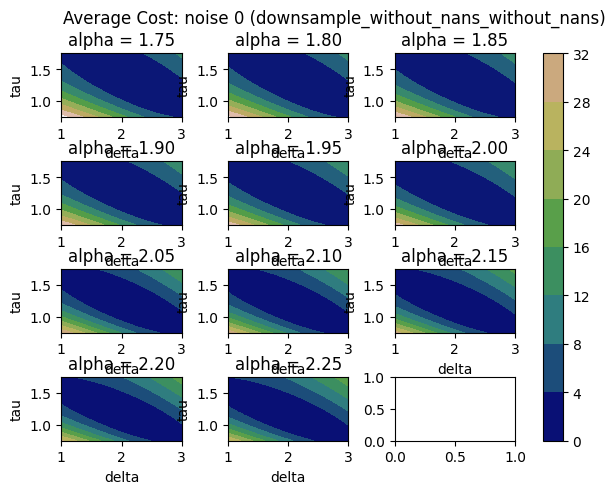

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              36.411810             
2                                              35.596828             
4                                              34.775000             
6                                              33.947084             
8                                              33.113866             
...                                                  ...             
18932                                          15.678549             
18934                                          16.426107             
18936                                          17.166672             
18938                                          17.899218             
18940                                          18.622823             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.15, Alpha target: 2


delta   tau  alpha
0   2.25  1.15    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.15, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  2.980361e-03   2.15  1.10   2.20
1      0         0  1.360445e-28   2.25  1.15   2.00
2      0         0  3.064321e-03   2.30  1.20   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.2561112078482801e-28; at
       delta   tau  alpha
11737   2.25  1.15    2.0


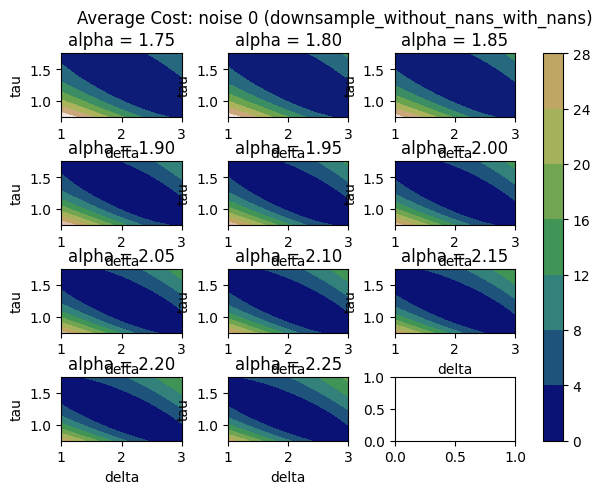

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              33.568989          
3                                              32.862793          
5                                              32.147857          
7                                              31.424824          
9                                              30.694371          
...                                                  ...          
18933                                          14.460666          
18935                                          15.125501          
18937                                          15.781319          
18939                                          16.427223          
18941                                          17.062426          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.15, Alpha target: 2


delta   tau  alpha
0   2.25  1.15    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.15, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  2.954851e-03   2.15  1.10   2.20
1      0         0  1.256111e-28   2.25  1.15   2.00
2      0         0  3.025050e-03   2.30  1.20   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0078707189653726; at
       delta   tau  alpha
11736   2.25  1.15    2.0


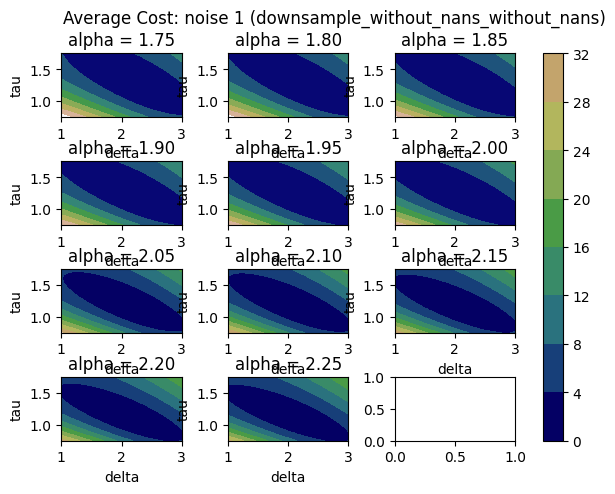

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.009671834772; at
       delta   tau  alpha
11736   2.25  1.15    2.0


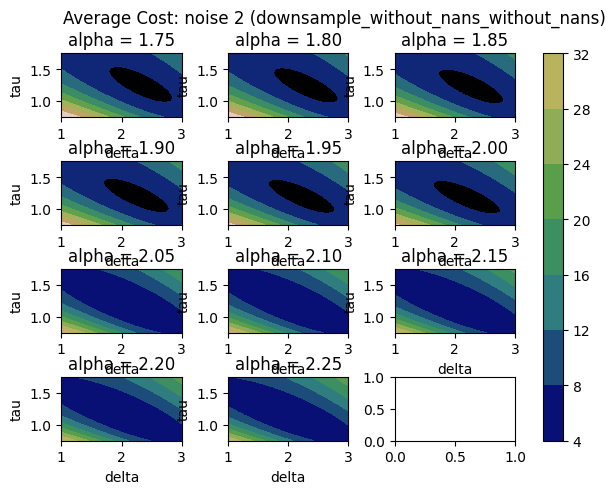

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.060264628335938; at
       delta   tau  alpha
11736   2.25  1.15    2.0


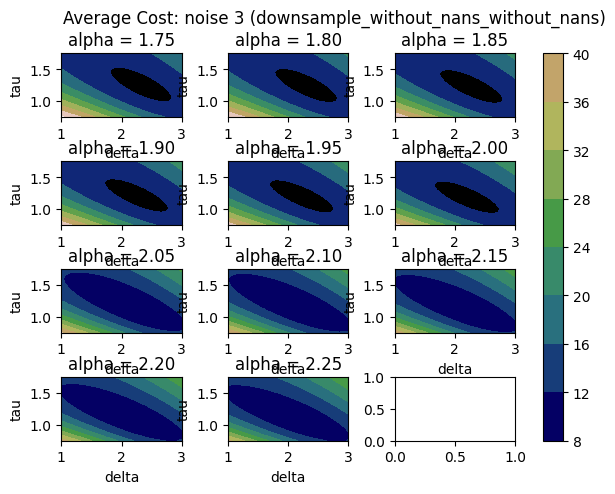

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.193100886405954; at
       delta   tau  alpha
11736   2.25  1.15    2.0


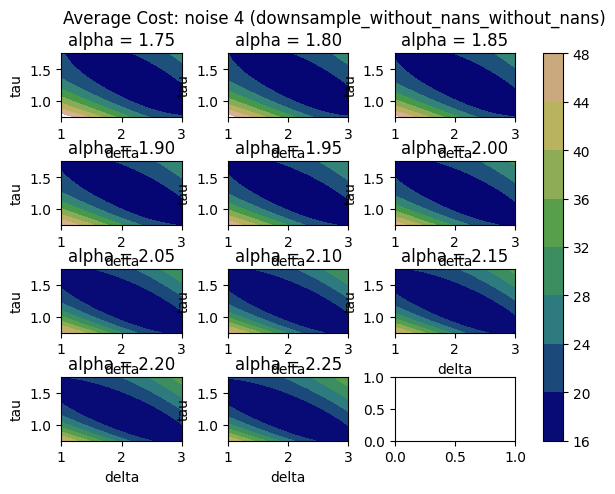

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.10631622529759; at
       delta   tau  alpha
11736   2.25  1.15    2.0


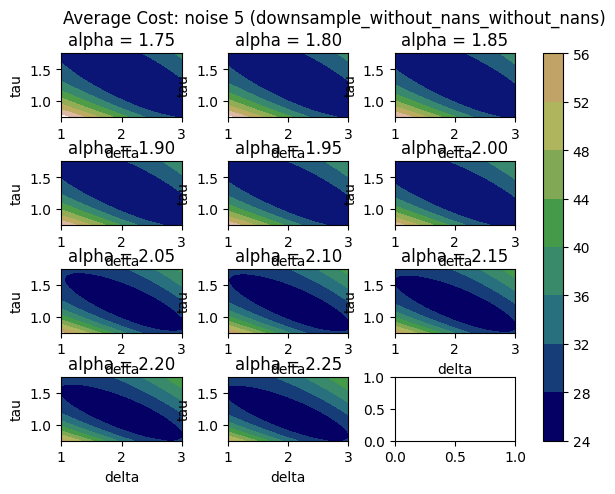

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.06831025203554; at
       delta  tau  alpha
10798   2.15  1.1    2.2


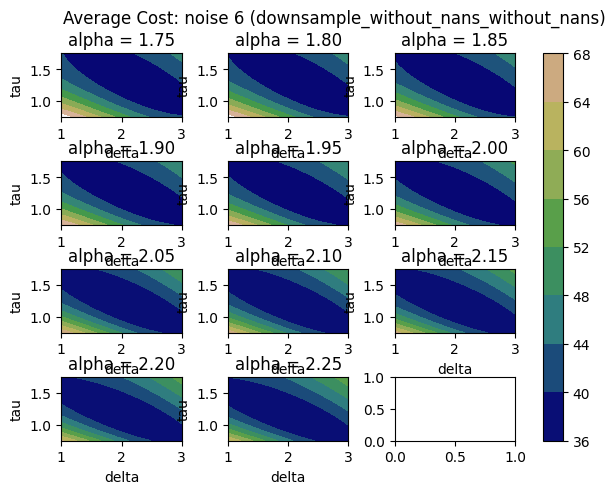

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.197025418042465; at
       delta  tau  alpha
12674   2.35  1.2    1.8


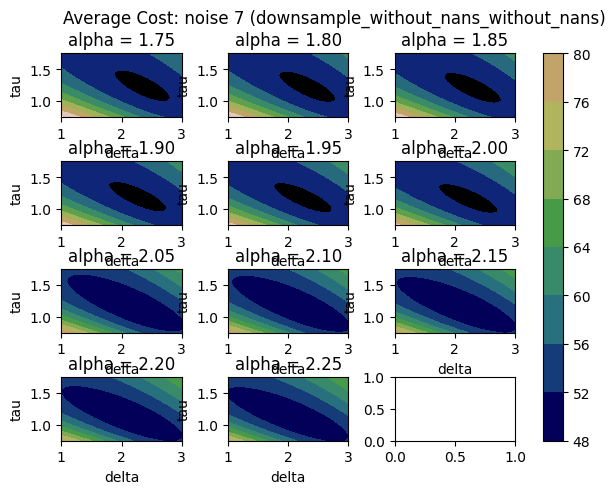

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.47962222286884; at
       delta  tau  alpha
12676   2.35  1.2   1.85


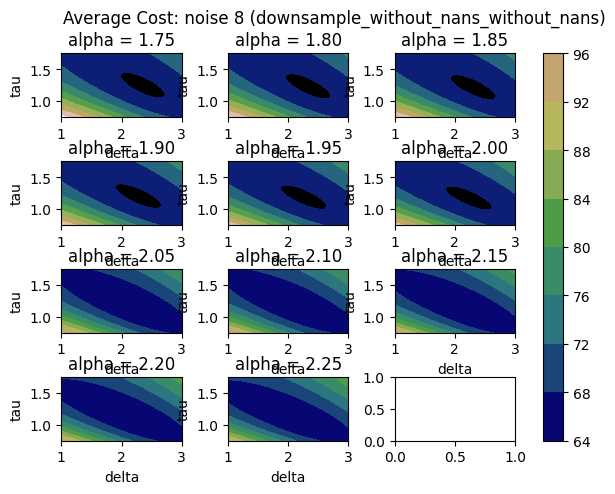

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.79262727904364; at
       delta  tau  alpha
12214    2.3  1.2   1.85


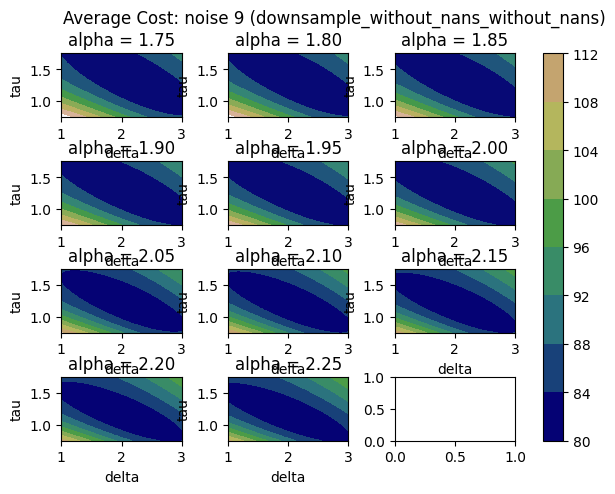

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 98.84402517837418; at
       delta   tau  alpha
11736   2.25  1.15    2.0


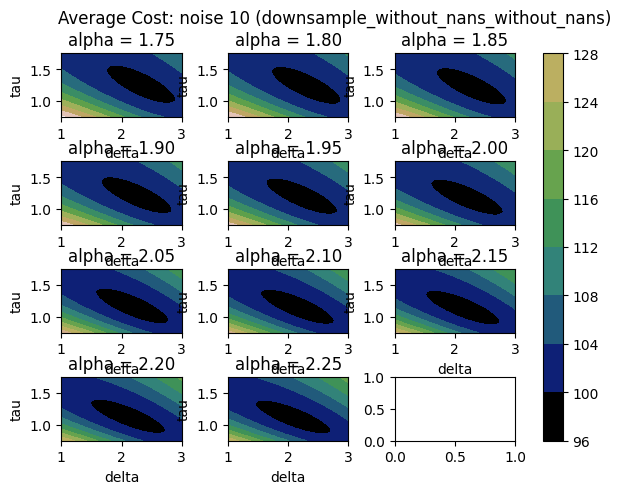

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

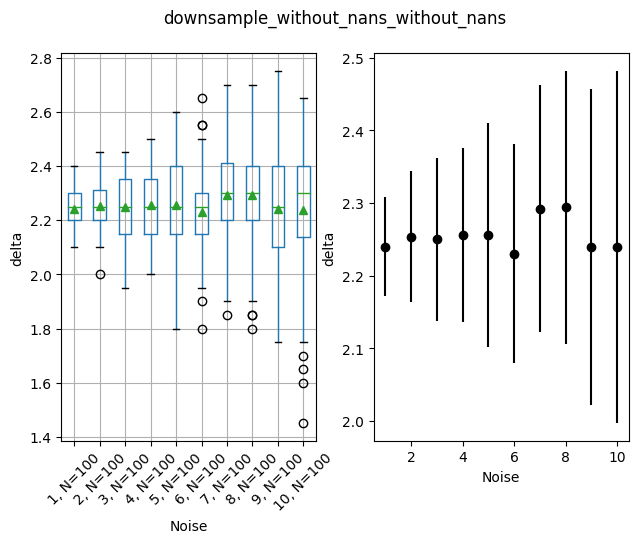

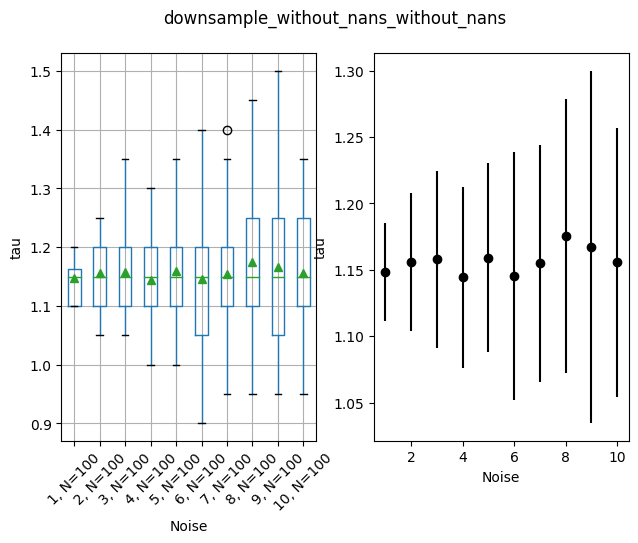

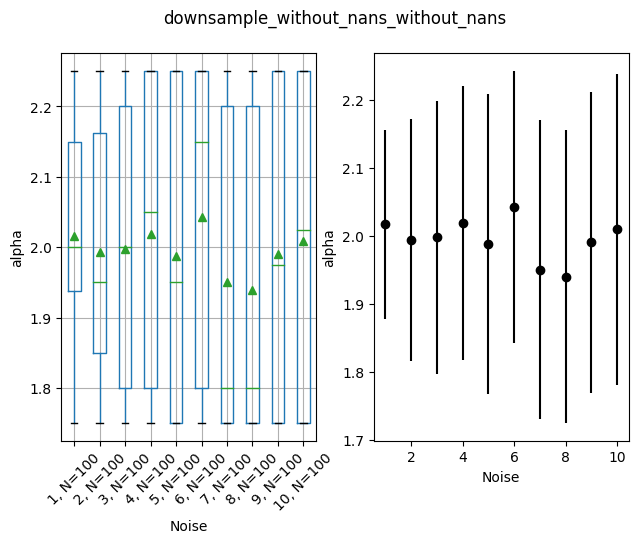

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0082987224958524; at
       delta   tau  alpha
11737   2.25  1.15    2.0


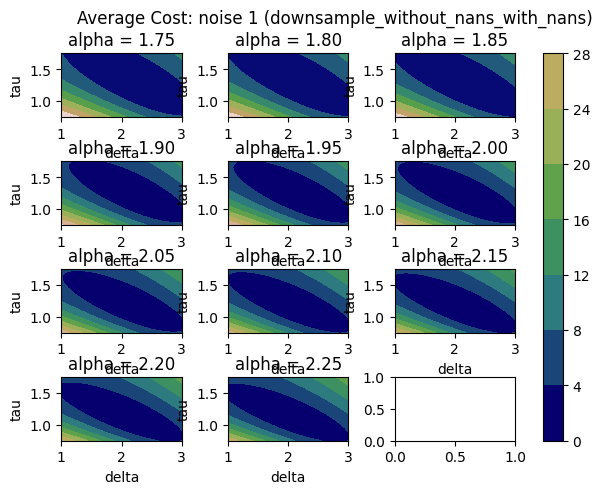

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.0005703132108685; at
       delta   tau  alpha
11737   2.25  1.15    2.0


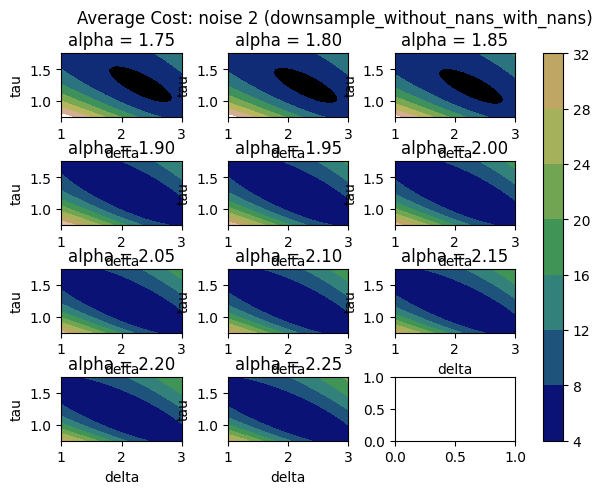

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.016148267773621; at
       delta   tau  alpha
11737   2.25  1.15    2.0


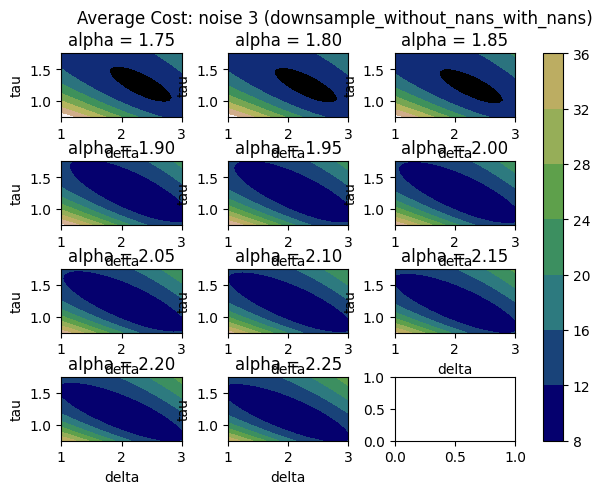

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.183558703870982; at
       delta   tau  alpha
11737   2.25  1.15    2.0


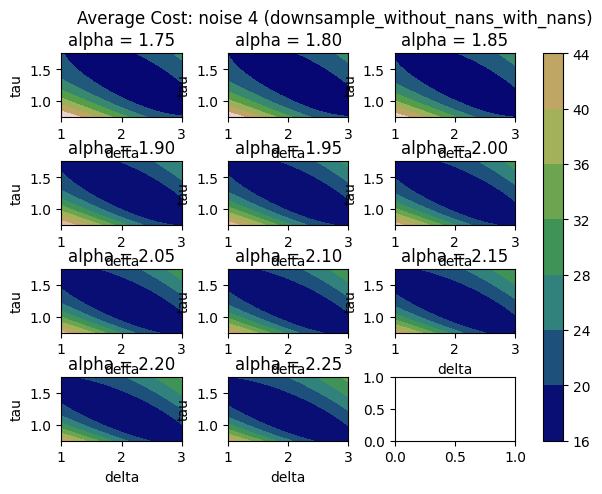

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.10278119951475; at
       delta   tau  alpha
11737   2.25  1.15    2.0


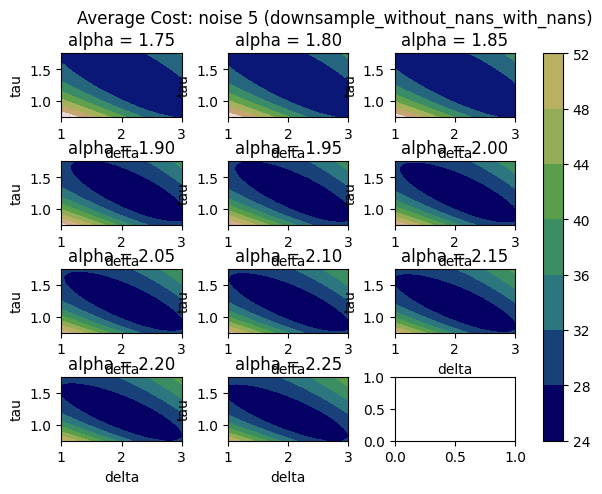

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.19089569374392; at
       delta  tau  alpha
10799   2.15  1.1    2.2


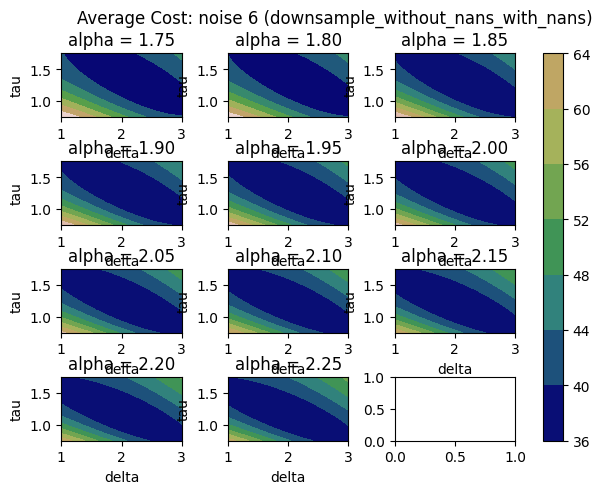

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.284141830259294; at
       delta  tau  alpha
12675   2.35  1.2    1.8


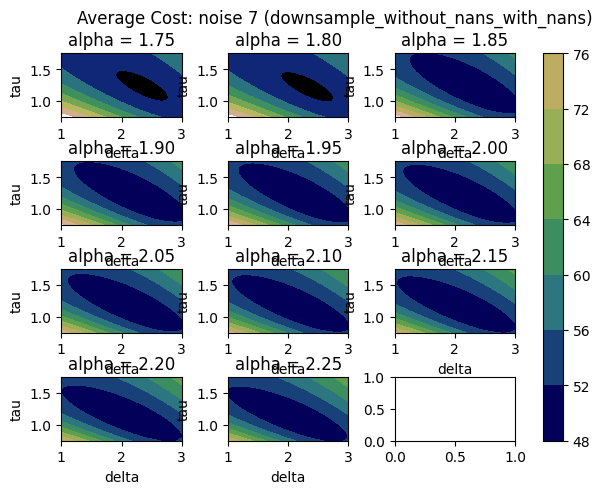

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.47813284530906; at
       delta  tau  alpha
12677   2.35  1.2   1.85


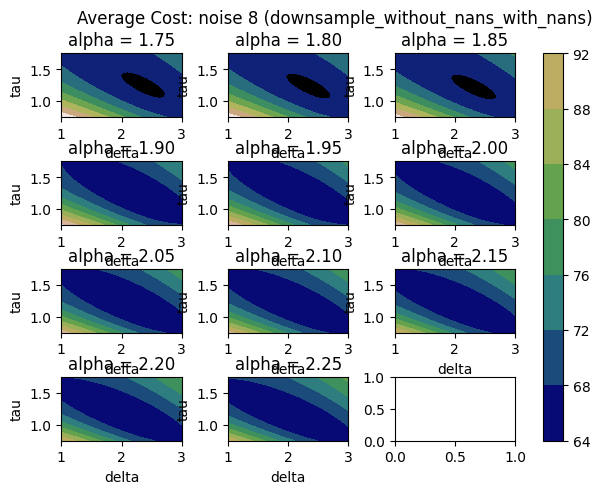

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.91785335642717; at
       delta  tau  alpha
12215    2.3  1.2   1.85


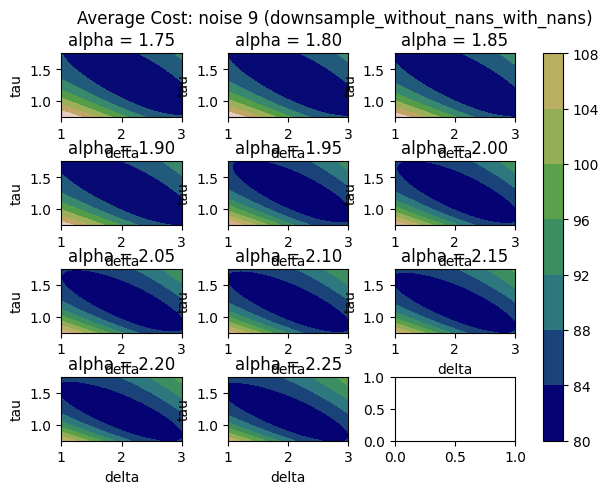

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 98.97430402362889; at
       delta   tau  alpha
11737   2.25  1.15    2.0


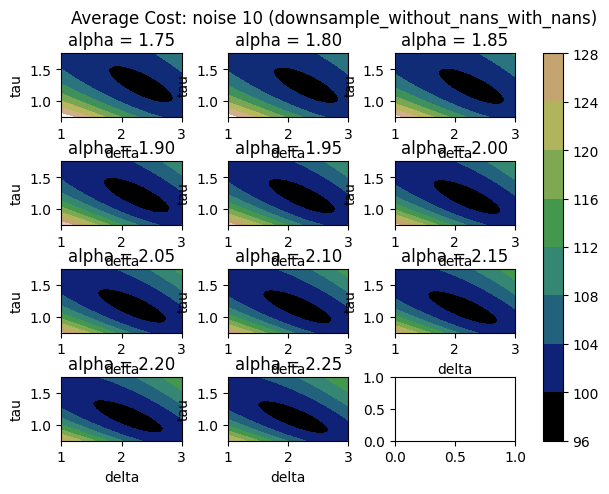

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


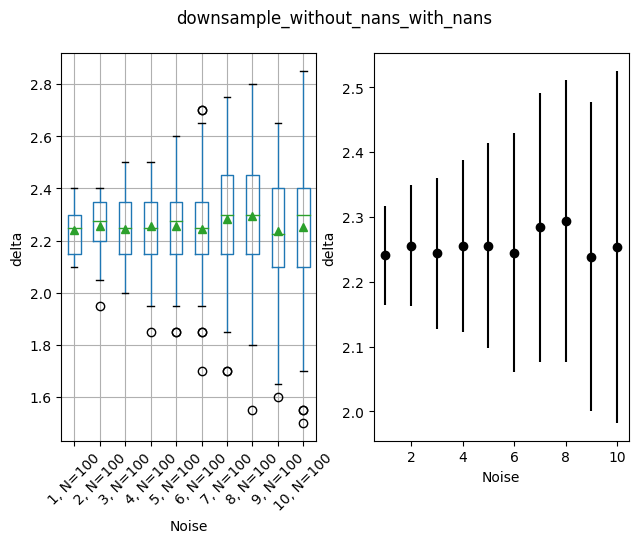

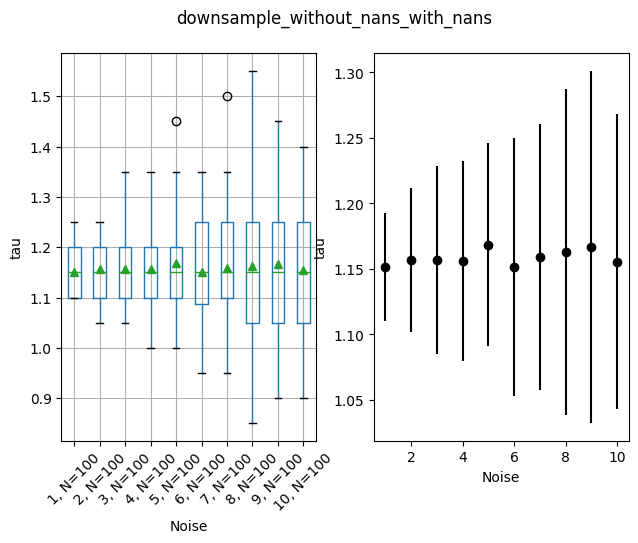

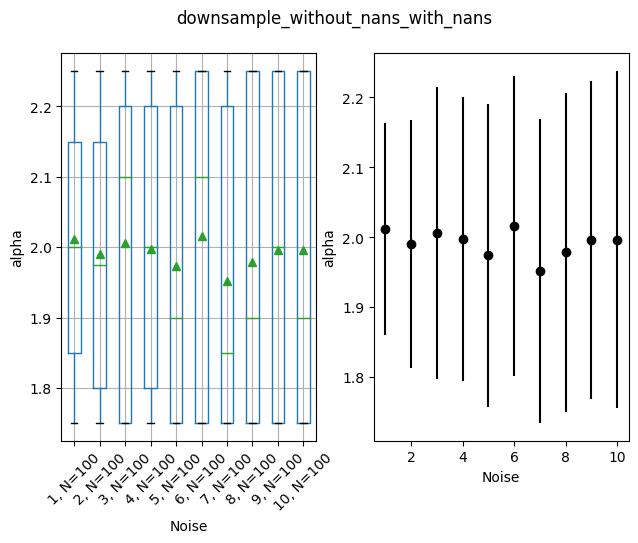

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration       cost               delta                 tau  \
0         1        56   0.979974   2.100000000000001  1.1000000000000003   
1         1         1   1.051183   2.100000000000001  1.1000000000000003   
2         1        15   1.093131   2.100000000000001  1.1000000000000003   
3         1        25   1.029371   2.100000000000001  1.1000000000000003   
4         1        28   1.027683   2.100000000000001  1.1000000000000003   
...     ...       ...        ...                 ...                 ...   
2627     10        27  98.153541  2.6000000000000014  1.2000000000000004   
2628     10        13  91.302198  2.6500000000000012  1.1000000000000003   
2629     10        27  98.147570  2.6500000000000012  1.2500000000000004   
2630     10        68  98.286778  2.7500000000000018  0.9500000000000002   
2631     10        68  98.303572  2.8000000000000016  1.0500000000000003   

                   alpha  
0                    2.2  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2627                1.85  
2628                 1.8  
2629                1.75  
2630  2.2500000000000004  
2631  1.9500000000000002  

[2632 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.19  0.419114  2.0  3.0  3.0  3.0  4.0
2                      100.0  3.23  0.565953  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.88  0.844232  1.0  2.0  3.0  3.0  4.0
4                      100.0  2.97  0.822106  1.0  3.0  3.0  4.0  4.0
5                      100.0  2.45  0.988571  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.60  1.054093  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.49  1.096321  1.0  1.0  3.0  3.0  4.0
8                      100.0  2.31  1.143228  1.0  1.0  3.0  3.0  4.0
9                      100.0  2.07  1.056533  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.13  1.142874  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
261       1        15    1.106215   2.300000000000001  1.2500000000000004   
262       1        25    1.036017   2.300000000000001  1.2500000000000004   
263       1        28    1.027270   2.300000000000001  1.2500000000000004   
264       1        42    0.986447   2.300000000000001  1.2500000000000004   
265       1        61    1.016168   2.300000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2621     10        81  102.548117  2.5500000000000016  1.1500000000000004   
2623     10        61  101.763554  2.5500000000000016  1.2500000000000004   
2624     10        52  100.655519  2.5500000000000016  1.3000000000000005   
2626     10         8   95.059805  2.6000000000000014  1.1000000000000003   
2629     10        27   98.147570  2.6500000000000012  1.2500000000000004   

     alpha  
261   1.75  
262   1.75  
263   1.75  
264   1.75  
265   1.75  
...    ...  
2621  1.75  
2623  1.75  
2624  1.75  
2626  1.75  
2629  1.75  

[393 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        22      3  2.3500000000000014   12    22      2  1.2500000000000004   
10       45     14  2.3500000000000014    7    45      8  1.2500000000000004   
2        35      5   2.300000000000001   11    35      3  1.2500000000000004   
3        34      5  2.3500000000000014   11    34      5  1.2500000000000004   
4        36      7  2.4000000000000012    8    36      4  1.2000000000000004   
5        39      8  2.3500000000000014    9    39      5  1.2000000000000004   
6        32     11   2.300000000000001    6    32      7  1.2500000000000004   
7        51     11   2.450000000000001   10    51      7  1.2000000000000004   
8        55     15   2.250000000000001    8    55      9  1.2500000000000004   
9        44     16   2.300000000000001    7    44     10  1.2000000000000004   

            
      freq  
noise       
1       18  
10      12  
2       21  
3       17  
4       17  
5       16  
6       12  
7       15  
8       14  
9       10

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
1         1         1    1.051183   2.100000000000001  1.1000000000000003   
2         1        15    1.093131   2.100000000000001  1.1000000000000003   
3         1        25    1.029371   2.100000000000001  1.1000000000000003   
4         1        28    1.027683   2.100000000000001  1.1000000000000003   
5         1        37    0.910416   2.100000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2580     10        27   98.166972  2.4000000000000012  1.1000000000000003   
2593     10        97  105.048789   2.450000000000001  0.9500000000000002   
2609     10        66   98.669372  2.5000000000000013  0.9500000000000002   
2625     10        68   98.280510  2.6000000000000014  1.0000000000000002   
2630     10        68   98.286778  2.7500000000000018  0.9500000000000002   

                   alpha  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
...                  ...  
2580  2.2500000000000004  
2593  2.2500000000000004  
2609  2.2500000000000004  
2625  2.2500000000000004  
2630  2.2500000000000004  

[400 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        21      3   2.100000000000001   13    21      2  1.1000000000000003   
10       57     21   2.250000000000001    9    57      8  1.0500000000000003   
2        39      6   2.100000000000001   16    39      3  1.1000000000000003   
3        42      6   2.100000000000001   10    42      3  1.1000000000000003   
4        43      7   2.250000000000001   12    43      4  1.1000000000000003   
5        41     11   2.100000000000001    7    41      6  1.0500000000000003   
6        42     11   2.200000000000001    9    42      6  1.1000000000000003   
7        40     12   2.200000000000001    8    40      6  1.1000000000000003   
8        33     15  1.9500000000000008    4    33      5  1.1500000000000004   
9        42     20   2.300000000000001    6    42      9  1.0500000000000003   

            
      freq  
noise       
1       19  
10      15  
2       27  
3       24  
4       18  
5       15  
6       13  
7       14  
8       10  
9       10

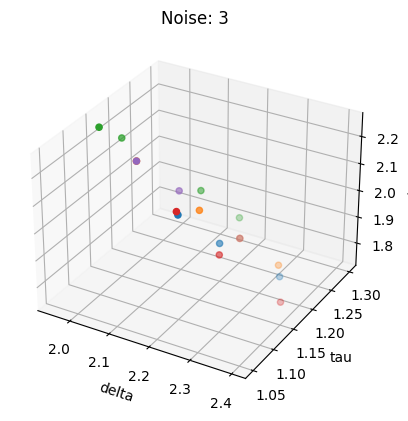

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

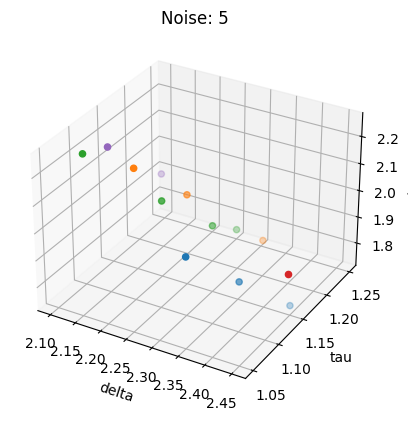

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

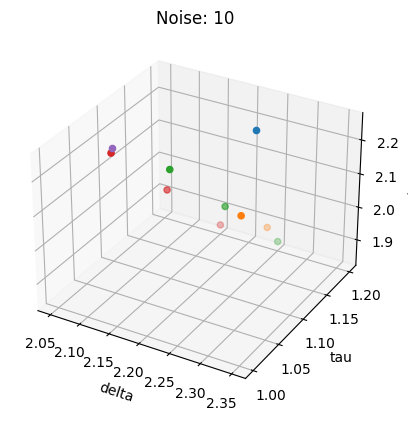

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration       cost               delta                 tau  \
0         1         1   1.075368   2.100000000000001  1.1000000000000003   
1         1        15   1.010504   2.100000000000001  1.1000000000000003   
2         1        25   1.010480   2.100000000000001  1.1000000000000003   
3         1        28   1.031825   2.100000000000001  1.1000000000000003   
4         1        42   1.002205   2.100000000000001  1.1000000000000003   
...     ...       ...        ...                 ...                 ...   
2532     10        27  99.463192  2.7500000000000018  1.2000000000000004   
2533     10        68  99.890816  2.8000000000000016  1.0500000000000003   
2534     10        27  99.454599  2.8000000000000016  1.2500000000000004   
2535     10        10  92.677901  2.8500000000000014  1.0000000000000002   
2536     10        68  99.881169  2.8500000000000014  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2532  1.9000000000000001  
2533  1.9000000000000001  
2534                1.75  
2535                1.75  
2536                1.75  

[2537 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.18  0.457927  2.0  3.0  3.0  3.0  4.0
2                      100.0  3.22  0.595946  2.0  3.0  3.0  4.0  4.0
3                      100.0  2.91  0.900000  1.0  2.0  3.0  4.0  4.0
4                      100.0  2.77  1.003579  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.34  1.156623  1.0  1.0  2.0  3.0  4.0
6                      100.0  2.58  1.065340  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.36  1.123846  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.06  1.108461  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.06  1.052366  1.0  1.0  2.0  3.0  4.0
10                     100.0  1.89  0.983654  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration       cost               delta                 tau alpha
261       1        28   1.024630   2.300000000000001  1.2500000000000004  1.75
262       1        42   1.018598   2.300000000000001  1.2500000000000004  1.75
263       1        45   0.970659   2.300000000000001  1.2500000000000004  1.75
264       1        51   0.982965   2.300000000000001  1.2500000000000004  1.75
265       1        59   0.981687   2.300000000000001  1.2500000000000004  1.75
...     ...       ...        ...                 ...                 ...   ...
2528     10        13  90.411279  2.6500000000000012  1.1000000000000003  1.75
2530     10         8  99.566509  2.7000000000000015  1.0500000000000003  1.75
2534     10        27  99.454599  2.8000000000000016  1.2500000000000004  1.75
2535     10        10  92.677901  2.8500000000000014  1.0000000000000002  1.75
2536     10        68  99.881169  2.8500000000000014  1.1000000000000003  1.75

[424 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        21      3  2.3500000000000014   12    21      2  1.2500000000000004   
10       45     16  2.5500000000000016    6    45      9  1.2000000000000004   
2        32      3  2.3500000000000014   13    32      2  1.2500000000000004   
3        48      7   2.300000000000001   13    48      5  1.2500000000000004   
4        38      7  2.3500000000000014   12    38      5  1.2000000000000004   
5        48     11  2.3500000000000014   12    48      6  1.2000000000000004   
6        42     13  2.3500000000000014    8    42      6  1.2500000000000004   
7        50     12  2.4000000000000012    8    50      8  1.2000000000000004   
8        49     18  2.3500000000000014    6    49     11  1.3000000000000005   
9        51     16   2.200000000000001    6    51     10  1.2000000000000004   

            
      freq  
noise       
1       19  
10       9  
2       18  
3       22  
4       16  
5       17  
6       13  
7       12  
8       11  
9       12

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         1    1.075368   2.100000000000001  1.1000000000000003   
1         1        15    1.010504   2.100000000000001  1.1000000000000003   
2         1        25    1.010480   2.100000000000001  1.1000000000000003   
3         1        28    1.031825   2.100000000000001  1.1000000000000003   
4         1        42    1.002205   2.100000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2496     10        68   99.875902   2.450000000000001  1.0500000000000003   
2497     10         0  107.298712   2.450000000000001  1.1000000000000003   
2511     10        11   96.714746  2.5500000000000016  0.9500000000000002   
2523     10        27   99.482560  2.6000000000000014  1.1000000000000003   
2525     10        10   92.733310  2.6500000000000012  0.9000000000000001   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2496  2.2500000000000004  
2497  2.2500000000000004  
2511  2.2500000000000004  
2523  2.2500000000000004  
2525  2.2500000000000004  

[421 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        24      3   2.100000000000001   13    24      2  1.1000000000000003   
10       63     23   2.300000000000001    8    63     10  1.1000000000000003   
2        32      5   2.200000000000001   12    32      2  1.1000000000000003   
3        43      6   2.100000000000001   16    43      4  1.1000000000000003   
4        41     11  2.1500000000000012    8    41      5  1.0500000000000003   
5        37     10   2.200000000000001    9    37      5  1.1000000000000003   
6        50     12   2.100000000000001    7    50      6  1.1000000000000003   
7        42     14   2.300000000000001    7    42      8  1.0500000000000003   
8        45     18  1.9500000000000008    5    45      8  1.1000000000000003   
9        44     17   2.000000000000001    7    44     10  1.0500000000000003   

            
      freq  
noise       
1       22  
10      18  
2       17  
3       23  
4       17  
5       17  
6       15  
7       10  
8       14  
9        9

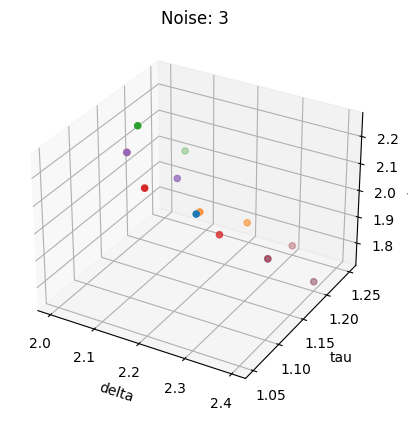

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

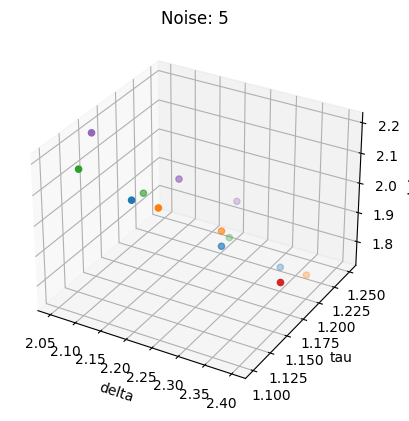

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

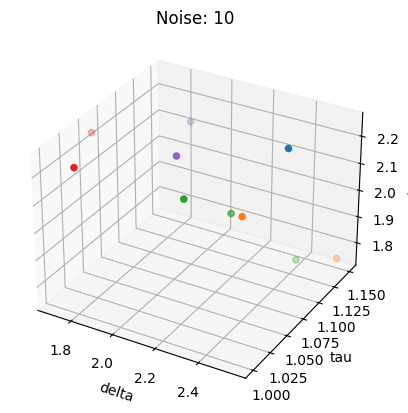

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()